# Problem 5. Perceptron for binary classification from scratch

## This is a homework: put your names here

- `First student name: Paul Zhang`

## Description

The goal of this homework is to build and train a neural network *by hand,* much like we did in class.

- To keep things as simple as possible we consider a simple *perceptron* with *one hidden layer*
- We consider a binary-classification problem which cannot be solved with a linear classifier
- We use a toy dataset which is already created for you with the `load_data()` function

The neural network will have to be **programmed and trained from scratch**, meaning that you will have to define its structure yourself, and that **you are not allowed** to use the built-in functionalities of `PyTorch` for autodifferentiation. You will have to program the forward and backward pass *yourself*, together with the gradient descent algorithm.

**Read the following instructions carefully in order to succeed**

- You are already provided with a simple python class which will constitute your neural network. 

- The constructor of this class (`__init__`) requires you to specify the following parameters (investigate the data carefully in order to know how these parameters need to be defined).
    - Number of input nodes (number of features)
    - Number of hidden units 
    - Number of output nodes

- The constructor of the neural network also requires you to allocate the weight matrices and bias vectors which will be the main components of your computational graph. For this, you can use some of the tensor operations we have seen in class, in order to initialize at random the weights, for instance.

- Implementing a neural network consists in two main steps:
    - Forward-pass: computing the output of the network based on its weight matrices and bias vectors. Since we consider binary classification, we should output activations that are activated by a sigmoid
    - Backward-pass: computing how different the predictions of the network are from what should be predicted and update the parameters of the network with the backpropagation algorithm. You are already provided with a loss function in the code which requires only slight modifications.

- If you want to challenge yourself you can extend the neural network as follows:
    - add multiple hidden layers of different sizes
    - explore different non-linear activation functions
    - investigate whether the network starts overfitting

In [58]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

### Enabling GPU

In [59]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda:0")

## Simulation of the data

In [60]:
def load_data(num_samples, num_features):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=num_samples,
        n_features=num_features, # was 2
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [61]:
gaussian_quantiles = load_data(num_samples = 500, num_features = 2)
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


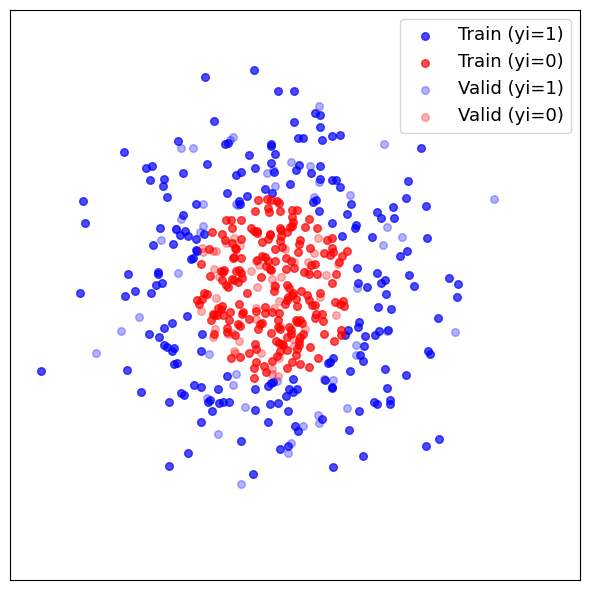

In [62]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

**QUESTION 5A.** What are the dimensions of the input? How many classes do we have? What do the classification labels correspond to? Look up the make_gaussian_quantiles function for the third question.

In [63]:
print("Dimension of inputs: {}\nNum of classes: {}".format(X_train.shape, np.unique(y_train).shape[0]))

Dimension of inputs: (400, 2)
Num of classes: 2


The labels correspond to the interger labels for quantile membership of the $\chi^2$ distribution of each sample. (quoted from the sklearn docs)

## A neural network class

**QUESTION 5B.** Implement the `forward` and `backward` methods in the following class, and fill the `__init__` and `train` methods, in order to train the one-hidden layer perceptron for binary classification. 

In [64]:
class EarlyStopper:
    def __init__(self, threshold = float("inf"), epsilon = float("inf")):
        self.threshold = threshold
        self.epsilon = epsilon
        self.counter = 0
        self.min_valid_loss = float('inf')

    def early_stop(self, valid_loss):
        if valid_loss < self.min_valid_loss:
            self.min_valid_loss = valid_loss
            self.counter = 0
        elif valid_loss > (self.min_valid_loss + self.epsilon):
            self.counter += 1
            if self.counter >= self.threshold:
                return True
        return False

class NeuralNetwork:
    def __init__(self, n_in, n_hidden, n_out):
        # number of input nodes
        self.n_x = n_in
        # number of hidden nodes
        self.n_h = n_hidden
        # number of output nodes
        self.n_y = n_out

        # Define 1st weight matrix (using random initialization)
        self.W1 = torch.rand(n_in, n_hidden) #np.sqrt(1 / n_in)
        # self.W1 = torch.normal(mean = 0, std = .01, size = (n_in, n_hidden)).to(device)

        # define 1st bias vector
        self.b1 = torch.rand(n_hidden)
        # self.b1 = torch.normal(mean = 0, std = 1, size = (n_hidden,)).to(device)
        
        # Define 2nd weight matrix (using random initialization)
        self.W2 = torch.rand(n_hidden, n_out) #np.sqrt(1 / n_hidden)
        # self.W2 = torch.normal(mean = 0, std = .01, size = (n_hidden, n_out)).to(device)

        # Define 2nd bias vector
        self.b2 = torch.rand(n_out)
        # self.b2 = torch.normal(mean = 0, std = 1, size = (n_out,)).to(device)
              
    def forward(self, X):
        hidden = torch.sigmoid(torch.mm(X, self.W1) + self.b1)
        # hidden = torch.relu(torch.mm(X, self.W1) + self.b1)
        output = torch.sigmoid(torch.mm(hidden, self.W2) + self.b2)
        return output
        
    def backward(self, X, y, learning_rate):
        z1 = torch.mm(X, self.W1) + self.b1
        a1 = torch.sigmoid(z1)
        # a1 = torch.relu(z1)
        z2 = torch.mm(a1, self.W2) + self.b2
        a2 = torch.sigmoid(z2)
        sigmoid_prime = lambda x: torch.sigmoid(x) * (1 - torch.sigmoid(x))
        relu_prime = lambda x: (x > 0).float()

        delta_loss = a2 - y.unsqueeze(1) # dL/dz2
        delta_W2 = torch.mm(a1.t(), delta_loss)
        delta_b2 = torch.sum(delta_loss, axis = 0)
        delta_z1 = torch.mm(delta_loss, self.W2.t()) * sigmoid_prime(z1)
        # delta_z1 = torch.mm(delta_loss, self.W2.t()) * relu_prime(z1)
        delta_W1 = torch.mm(X.t(), delta_z1)
        delta_b1 = torch.sum(delta_z1, axis = 0)

        N = X.shape[0]
        self.W1 -= learning_rate / N * delta_W1 # update of the 1st weight matrix
        self.b1 -= learning_rate / N * delta_b1 # update of the 1st bias vector
        self.W2 -= learning_rate / N * delta_W2 # update of the 2nd weight matrix
        self.b2 -= learning_rate / N * delta_b2 # update of the 2nd bias vector

    
    def score(self, y, y_pred, pct = True):
        # y_pred = (self.forward(X) > .5).float()
        return (1 - ((y_pred > .5).float() - y.unsqueeze(1)).abs().mean(axis = 0)).item() * (100**pct)

    def metrics(self, y, y_pred, pct = True):
        diff = 2 * (y.unsqueeze(1) + 1) - (y_pred > .5).float()
        FP = torch.sum(diff == 1.).item()
        TN = torch.sum(diff == 2.).item()
        TP = torch.sum(diff == 3.).item()
        FN = torch.sum(diff == 4.).item()
        precision = TP / (TP + FP) * (100**pct)
        recall = TP / (TP + FN) * (100**pct)
        f1 = 2 * precision * recall / (precision + recall)
        return precision, recall, f1

    def train_log(self, y_train, y_train_pred, y_valid, y_valid_pred, train_loss, valid_loss, curr_epoch, max_epoch, verbose):
        accuracy_train = self.score(y_train, y_train_pred)
        accuracy_valid = self.score(y_valid, y_valid_pred)
        if verbose: 
            print("Epoch %d/%d: Training Loss %.6f\tValidation Loss %.6f\tTraining accuracy %.2f%%\tValidation accuracy %.2f%%" %(curr_epoch, max_epoch, train_loss, valid_loss, accuracy_train, accuracy_valid))
        if verbose > 1:
            print("Precision %.2f%%\tRecall %.2f%%\tF1 Score %.6f" %self.metrics(y_train, y_train_pred))

    def train(self, X_train, y_train, X_valid, y_valid, epochs, learning_rate, stopper_args = None, verbose = 1, print_interval = 1000):
        stopper = EarlyStopper(**stopper_args)
        for e in range(epochs):
            xe_loss = lambda y, y_pred: -torch.mean(torch.mul(torch.log(y_pred), y.unsqueeze(1)) + torch.mul(torch.log(1 - y_pred),  (1 - y.unsqueeze(1)))) 

            y_train_pred = torch.clamp(self.forward(X_train), 1e-7, 1 - 1e-7)
            training_loss = xe_loss(y_train, y_train_pred)
            
            self.backward(X_train, y_train, learning_rate)
            y_valid_pred = torch.clamp(self.forward(X_valid), 1e-7, 1 - 1e-7)
            valid_loss = xe_loss(y_valid, y_valid_pred)
            
            # self.W1 -= # update of the 1st weight matrix
            # self.b1 -= # update of the 1st bias vector
            # self.W2 -= # update of the 2nd weight matrix
            # self.b2 -= # update of the 2nd bias vector

            if not (e+1) % print_interval:
                self.train_log(y_train, y_train_pred, y_valid, y_valid_pred, training_loss, valid_loss, e+1, epochs, verbose)
            if stopper.early_stop(valid_loss):
                print("[Early stopping]")
                self.train_log(y_train, y_train_pred, y_valid, y_valid_pred, training_loss, valid_loss, e+1, epochs, verbose)
                break

**QUESTION 5C.** Train your neural network, modify your code to save the training and validation error along the gradient descent iterations and plot them. You should also print the train and validation errors during training.

In [69]:
n_samples = 5000; num_features = 5
gaussian_quantiles = load_data(n_samples, num_features)
X, y = gaussian_quantiles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_torch = torch.from_numpy(X_train).float().to(device)
y_train_torch = torch.from_numpy(y_train).float().to(device)
X_valid_torch = torch.from_numpy(X_test).float().to(device)
y_valid_torch = torch.from_numpy(y_test).float().to(device)

nn = NeuralNetwork(X_train.shape[1], 10, 1)

nn.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs = 200000,
    learning_rate = 0.2,
    verbose = 2,
    print_interval = 20000,
    stopper_args = {"threshold": 10, "epsilon": 0}
)

Epoch 20000/200000: Training Loss 0.137786	Validation Loss 0.167188	Training accuracy 95.75%	Validation accuracy 94.40%
Precision 95.51%	Recall 95.99%	F1 Score 95.745746
Epoch 40000/200000: Training Loss 0.111628	Validation Loss 0.141201	Training accuracy 96.40%	Validation accuracy 95.20%
Precision 96.16%	Recall 96.64%	F1 Score 96.396396
Epoch 60000/200000: Training Loss 0.099770	Validation Loss 0.129524	Training accuracy 96.97%	Validation accuracy 94.80%
Precision 96.99%	Recall 96.94%	F1 Score 96.963614
Epoch 80000/200000: Training Loss 0.092274	Validation Loss 0.122155	Training accuracy 97.28%	Validation accuracy 94.60%
Precision 97.05%	Recall 97.49%	F1 Score 97.271589
Epoch 100000/200000: Training Loss 0.086938	Validation Loss 0.116895	Training accuracy 97.50%	Validation accuracy 94.90%
Precision 97.40%	Recall 97.59%	F1 Score 97.493734
Epoch 120000/200000: Training Loss 0.082851	Validation Loss 0.112909	Training accuracy 97.55%	Validation accuracy 95.10%
Precision 97.49%	Recall 97.5

**QUESTION 5D.** Modify the training code to display and save the true positives, false positives, true negatives, false negatives, precision, recall, and f1 score during training (that is, as epochs progress).

Done. btw I think there is no need to print the numbers of TP, FP, etc., since we already have precision, recall, accuracy, and sample size.